In [1]:
%matplotlib inline
%run /Users/marisa/git/practice/Sampler.py
import math
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

random.seed(123)
np.random.seed(123) #scipy uses this one.

/Users/marisa/miniconda3/envs/py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2712: DtypeWarning: Columns (19,25,26,27,28,29,35,36,41,42,43,48,49,51,53,55,56,58,59,60,62,63,117,119) have mixed types. Specify dtype option on import or set low_memory=False.
  self.compile if shell_futures else None)


In [2]:
# Load NOAA Precip data and deal with flags in numeric column
df2 = getAndCleanPrecip()
df2.shape

/Users/marisa/miniconda3/envs/py3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (19,25,26,27,28,29,35,36,41,42,43,48,49,51,53,55,56,58,59,60,62,63,117,119) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


(3285, 2)

min=0.0, max=5.2


<function print>

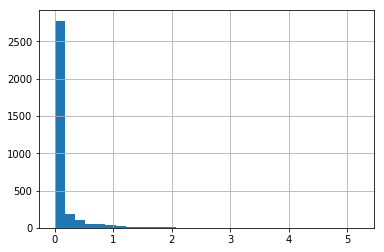

In [3]:
df2['precipNum'].hist(bins=30)
print(f"min={df2['precipNum'].min()}, max={df2['precipNum'].max()}")
print

In [4]:
###### RUNNER FOR THE BAYESIAN GENERATIVE MODEL #######
# Steps
# 1. Get some priors
# 2. Sample from the priors
# 3. Generate likelihood from the candidate parameter set with data
# 4. Do Metropolis Hastings step

random.seed(123)
np.random.seed(123)

lambdaPrior = LambdaPrior(1, 1)
expModel = ExpModel(df2['precipNum'])
batchSize = 20
proposeStdDev = AdaptableProposalStdDev(0.02, batchSize)
lastLambda = 0
nIts = 10000
posteriors = Posterior(nIts)

#print(f'lambda\tposterior\tlastPost\trandNum')
for i in range(nIts):
    # Choose candidate lambda using prior and proposal distribution
    lastLambda = lambdaPrior.mean() if (i == 0) else posteriors.getLambda(i-1)
    candidateLambda = lambdaPrior.sample(lastLambda, proposeStdDev.stdDev)
    prior = lambdaPrior.logpdf(candidateLambda)

    # Calculate likelihood of data given candidate model
    # lambda * exp(-lambda*x) where scale = 1/lambda
    likelihood = expModel.likelihood(candidateLambda)

    # Use Metropolis Hastings to append to posterior distribution for lambda
    posteriors.append(i, candidateLambda, prior, likelihood)

    # Use acceptance rate to determine if there is too much hill climb or too much
    # wandering, and adjust proposal distribution standard deviation accordingly
    if ((i > 0) & (i % batchSize == 0)):  # adapt proposal stdDev once per batchSize
        proposeStdDev.adapt(posteriors.nAccepts, i)
        posteriors.nAccepts = 0 # reset for next batch


#print(f"{candidateLambda:.5f}\t{posterior:.2f}\t{posteriors.iloc[i-1]['posterior']:.2f}\t{r:.5f}")
#print(f"posterior={posteriors['posterior']}")


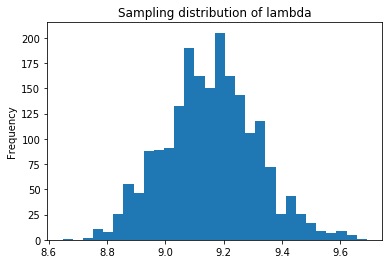

In [5]:
# using very conservative warmup
postWarmup = math.ceil(posteriors.postr.shape[0]*1/5)
posteriors.postr.tail(n=postWarmup)['lambda'].plot(kind='hist',
                                                   bins=30,
                                                   title='Sampling distribution of lambda')

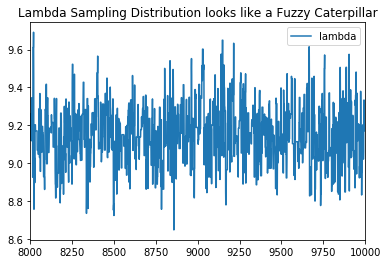

In [6]:
posteriors.postr.tail(n=postWarmup).plot(y='lambda', use_index=True, title="Lambda Sampling Distribution looks like a Fuzzy Caterpillar")

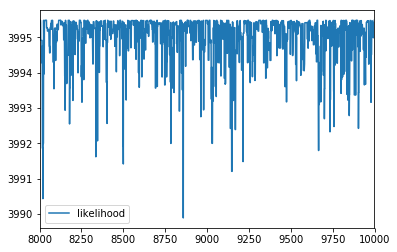

In [7]:
posteriors.postr.tail(n=postWarmup).plot(y='likelihood', use_index=True)

Text(0.5, 1.0, 'Converged early on to 0.44')

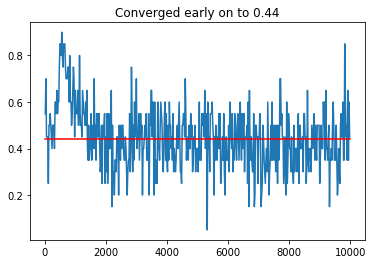

In [92]:
batchIterations = range(batchSize, nIts, batchSize)
plt.plot(batchIterations, proposeStdDev.acceptRate)
plt.plot(batchIterations, [proposeStdDev.targetAcceptRate]*len(batchIterations), "r")
plt.title(f"Converged early on to {proposeStdDev.targetAcceptRate}")